In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
i = 0
reverse_list = [0] * 8400
for hs, ws in [(80,80), (40,40), (20,20)]:
    for w in range(hs):
        for h in range(ws):
            reverse_list[i] = (int((640/hs)*(h+0.5)),int((640/ws)*(w+0.5)))
            i+=1

def convert_cwh_to_xyxy(box):
    cx, cy, w, h = box[:, :, 0], box[:, :, 1], box[:, :, 2], box[:, :, 3]
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return torch.stack((x1, y1, x2, y2), dim=2)

def generate_anchors(grid_size=0.05, dtype=torch.float32, device="cpu"):
    spatial_shapes = [[80,80], [40,40], [20,20]]
    anchors = []
    for lvl, (h, w) in enumerate(spatial_shapes):
        grid_y, grid_x = torch.meshgrid(
            torch.arange(end=h, dtype=dtype),
            torch.arange(end=w, dtype=dtype),
            indexing="ij",
        )
        grid_xy = torch.stack([grid_x, grid_y], -1)
        valid_WH = torch.tensor([w, h]).to(dtype)
        grid_xy = (grid_xy.unsqueeze(0) + 0.5) / valid_WH
        wh = torch.ones_like(grid_xy) * grid_size * (2.0**lvl)
        anchors.append(torch.concat([grid_xy, wh], -1).reshape(-1, h * w, 4))

    anchors = torch.concat(anchors, 1).to(device)
    valid_mask = ((anchors > 1e-2) * (anchors < 1 - 1e-2)).all(
        -1, keepdim=True
    )
    anchors = torch.log(anchors / (1 - anchors))
    anchors = torch.where(valid_mask, anchors, torch.inf)

    return anchors, valid_mask



def predict(input_tensor, model, detection_threshold):
    outputs = model(input_tensor)
    
    out_logits, out_bbox = outputs["pred_logits"], outputs["pred_boxes"]
    prob = out_logits.sigmoid()
    topk_values, topk_indexes = torch.topk(
        prob.view(out_logits.shape[0], -1), 300, dim=1
    )
    scores = topk_values
    labels = topk_indexes % out_logits.shape[2]
    boxes = convert_cwh_to_xyxy(out_bbox)    
    
    boxes = boxes[0].tolist()
    scores = scores[0].tolist()
    labels = labels[0].tolist()
    
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []

    for i in range(len(scores)):
        if scores[i] >= detection_threshold:
            filtered_boxes.append(boxes[i])
            filtered_scores.append(scores[i])
            filtered_labels.append(labels[i])

    return filtered_boxes, filtered_scores, filtered_labels
    

def draw_boxes(boxes, image):
    # print(boxes)
    img_w, img_h = image.size
    draw = ImageDraw.Draw(image)
    for (xmin, ymin, xmax, ymax)  in boxes:
        xmin, xmax = xmin*img_w, xmax*img_w
        ymin, ymax = ymin*img_h, ymax*img_h
        draw.rectangle(
        ((xmin, ymin), (xmax, ymax)), outline=(255, 0, 0), width=1)
                
    return image

def draw_points(input_tensor, idx, point_color=(0, 0, 255), point_size=2):
    xs, ys = [], []
    for i in idx:
        x,y = reverse_list[i]
        xs.append(x)
        ys.append(y)

    fig, ax = plt.subplots()

    input_tensor = input_tensor[0].cpu()
    image_numpy = input_tensor.permute(1, 2, 0).numpy()
    # 이미지 배경 설정
    ax.imshow(image_numpy)

    # scatter plot 그리기
    for x, y in zip(xs, ys):
        ax.scatter(x, y, s=10, c='red', marker='o')  # s: 점 크기, c: 색깔, marker: 모양

    # 축 범위 및 기타 설정 (optional)
    ax.set_xlim(0, image_numpy.shape[1])
    ax.set_ylim(image_numpy.shape[0], 0)  # y축 반전
    ax.set_aspect('equal')  # x, y 축 비율 동일하게 설정
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Points on Tensor Image")

    plt.show()

# 모델 불러오는 파트

In [3]:
from src.solver import TASKS
from src.core import YAMLConfig

config = '/home/prml/StudentsWork/Chanyoung/MODU/configs/MODU/tiny.yml'
pt_path = '/home/prml/StudentsWork/Chanyoung/MODU/weights/tiny.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [4]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()

_IncompatibleKeys(missing_keys=['norm0.weight', 'norm0.bias', 'norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['head.bias', 'head.weight', 'norm.bias', 'norm.weight'])
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
resume from /home/prml/StudentsWork/Chanyoung/MODU/weights/tiny.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict


MODU(
  (backbone): ConvNeXtV2(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm()
      )
      (1): Sequential(
        (0): LayerNorm()
        (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm()
        (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm()
        (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Block(
          (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=96, out_features=384, bias=True)
          (act): GELU(approximate='none')
          (grn): GRN()
          (pwconv2): Linear(in_features=384, out_features=96, bias=True)
          (drop_path): Identity()
    

In [5]:
def hook_get_enc_outputs_box(module, input, output):
    global enc_outputs_coord
    enc_outputs_coord = output

def hook_get_enc_outputs_class(module, input, output):
    global enc_outputs_logit
    enc_outputs_logit = output
    
def hook_get_encoder_feature(module, input, output):
    global encoder_feature
    encoder_feature = output

In [6]:
image = Image.open('/home/prml/StudentsWork/Chanyoung/MODU/dogs.jpg')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)


enc_outputs_box = model.decoder.enc_bbox_head
hook_1 = enc_outputs_box.register_forward_hook(hook_get_enc_outputs_box)
enc_outputs_class = model.decoder.enc_score_head
hook_2 = enc_outputs_class.register_forward_hook(hook_get_enc_outputs_class)
encoder_outputs_feature = model.encoder
hook_3 = encoder_outputs_feature.register_forward_hook(hook_get_encoder_feature)

# 모델 forward pass
output = model(input_tensor)

# Hook 제거
hook_1.remove()
hook_2.remove()
hook_3.remove()


torch.Size([1, 3, 640, 640])


In [7]:
len(output['pred_logits'][0][0])

80

In [8]:
print(enc_outputs_logit.shape) # 6400 1600 400
print(enc_outputs_coord.shape)

torch.Size([1, 8400, 80])
torch.Size([1, 8400, 4])


# seleted query 확인 부분

In [9]:
enc_outputs_logit = enc_outputs_logit.cpu()

anchor, _ = generate_anchors()
enc_outputs_coord = enc_outputs_coord.cpu()
enc_outputs_coord_unact = enc_outputs_coord + anchor

_, topk_ind = torch.topk(enc_outputs_logit.max(-1).values, 300, dim=1)


reference_points_unact = enc_outputs_coord_unact.gather(
    dim=1,
    index=topk_ind.unsqueeze(-1).repeat(
        1, 1, enc_outputs_coord_unact.shape[-1]
    ),
)

# topk_ind

[8205, 8209, 8213, 8226, 8245, 8174, 8234, 8285, 8230, 8166]
(176, 336). (304, 336). (432, 336). (208, 368). (176, 400). (464, 272). (464, 368). (176, 464). (336, 368). (208, 272). 

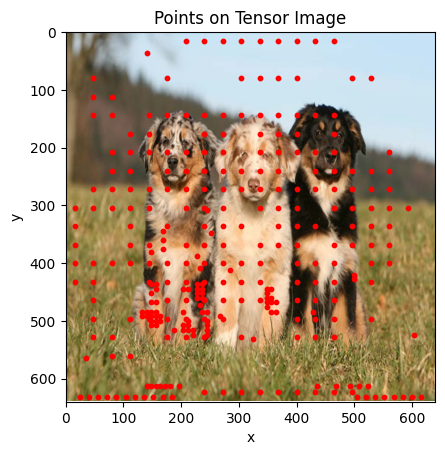

In [10]:
print(topk_ind.tolist()[0][:10])
for ind in topk_ind.tolist()[0][:10]:
    print(reverse_list[ind], end='. ')
    
draw_points(input_tensor, topk_ind.tolist()[0][:300])

In [11]:
feats_idx_x = [[] ,[], []]
feats_idx_y = [[] ,[], []]
for i in topk_ind.tolist()[0][:100]:
    print(i, end=' ')
    x, y = reverse_list[i]
    if i < 6400:
        feats_idx_x[0].append(x)
        feats_idx_y[0].append(y)
    elif i < 8000:
        feats_idx_x[1].append(x)
        feats_idx_y[1].append(y)
    else:
        feats_idx_x[2].append(x)
        feats_idx_y[2].append(y)

8205 8209 8213 8226 8245 8174 8234 8285 8230 8166 8186 8217 8170 8307 8195 8288 8194 8150 8265 8216 8188 8236 8305 8165 8268 8190 8212 8191 8192 8197 8154 8246 8250 8215 8313 8146 8175 4978 8287 8211 8249 8223 8228 8237 8203 8325 8173 8293 8196 8256 8231 8327 8232 8235 8208 8145 8126 5070 8134 8162 8198 8092 8333 8187 8087 8248 8306 8254 8308 8247 4589 8326 8312 8207 5146 8292 8183 8168 8252 4898 8108 4844 8184 8128 8082 8130 8227 4816 5058 8176 4818 4523 8167 8084 8155 8088 8289 8334 4658 8314 

# encoder feature 확인 부분

In [12]:
def sigmoid(x):
  """
  NumPy 배열 또는 스칼라 값에 대한 시그모이드 함수를 계산합니다.

  Args:
    x: NumPy 배열 또는 스칼라 값.

  Returns:
    x에 대한 시그모이드 함수 값 (NumPy 배열 또는 스칼라 값).
  """
  return 1 / (1 + np.exp(-x))

In [13]:
def relu(x):
  """
  NumPy 배열 또는 스칼라 값에 대한 ReLU 함수를 계산합니다.

  Args:
    x: NumPy 배열 또는 스칼라 값.

  Returns:
    x에 대한 ReLU 함수 값 (NumPy 배열 또는 스칼라 값).
  """
  return np.maximum(0, x)

In [14]:
print(len(encoder_feature))
print(encoder_feature[0].shape)
print(encoder_feature[1].shape)
print(encoder_feature[2].shape)

3
torch.Size([1, 256, 80, 80])
torch.Size([1, 256, 40, 40])
torch.Size([1, 256, 20, 20])


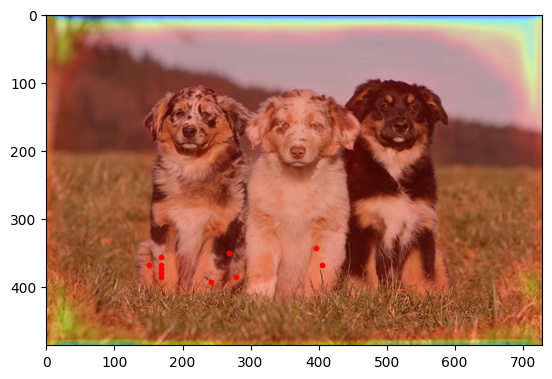

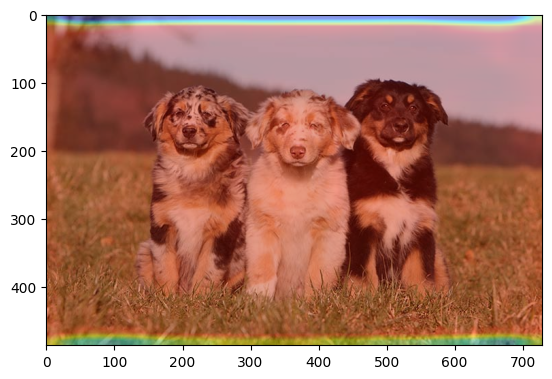

1.0


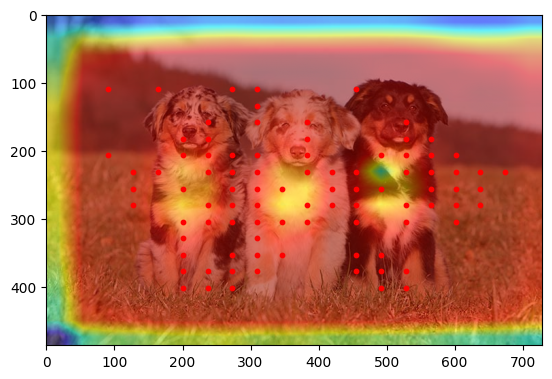

In [ ]:
# 히트맵 생성
temp_feat_0 = relu(encoder_feature[0].detach().cpu().numpy())
temp_feat_1 = relu(encoder_feature[1].detach().cpu().numpy())
temp_feat_2 = relu(encoder_feature[2].detach().cpu().numpy())


heatmap_0 = np.mean(temp_feat_0, axis=1).squeeze() # 채널 평균
heatmap_0 = cv2.resize(heatmap_0, (image.width, image.height)) # 이미지 크기로 조정
heatmap_0 = (heatmap_0 - np.min(heatmap_0)) / (np.max(heatmap_0) - np.min(heatmap_0))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_0), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[0]) / 640 * image.width
y = np.array(feats_idx_y[0]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()


heatmap_1 = np.mean(temp_feat_1, axis=1).squeeze() # 채널 평균
heatmap_1 = cv2.resize(heatmap_1, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_1 = heatmap_1 / np.max(heatmap_1)
heatmap_1 = (heatmap_1 - np.min(heatmap_1)) / (np.max(heatmap_1) - np.min(heatmap_1))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_1), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[1]) / 640 * image.width
y = np.array(feats_idx_y[1]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

heatmap_2 = np.mean(temp_feat_2, axis=1).squeeze() # 채널 평균
heatmap_2 = cv2.resize(heatmap_2, (image.width, image.height)) # 이미지 크기로 조정
heatmap_2 = (heatmap_2 - np.min(heatmap_2)) / (np.max(heatmap_2) - np.min(heatmap_2))
print(np.max(heatmap_2))
# 원본 이미지에 히트맵 겹치기
heatmap_2 = cv2.applyColorMap(np.uint8(255 * heatmap_2), cv2.COLORMAP_JET)
overlayed_image = heatmap_2 * 0.5 + np.array(image) * 0.5
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[2]) / 640 * image.width
y = np.array(feats_idx_y[2]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

(80, 80)


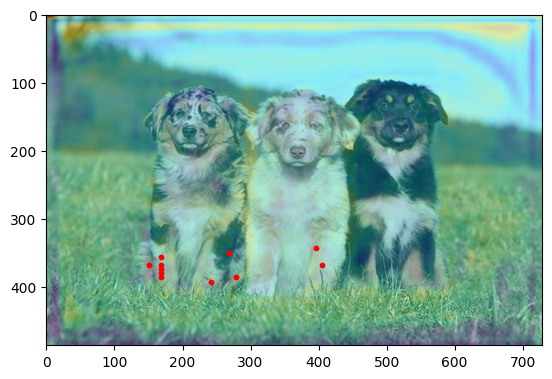

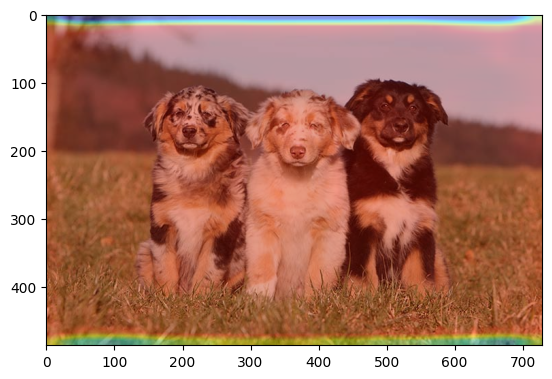

1.0


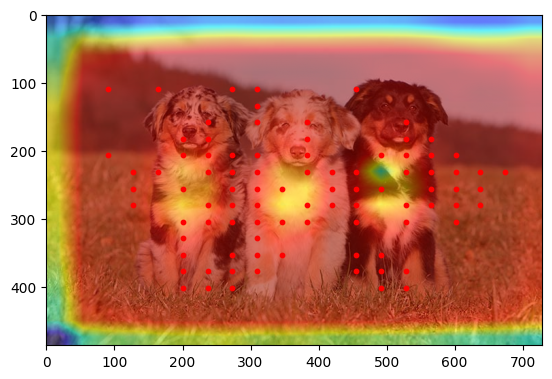

In [25]:
# 히트맵 생성
temp_feat_0 = relu(encoder_feature[0].detach().cpu().numpy())
temp_feat_1 = relu(encoder_feature[1].detach().cpu().numpy())
temp_feat_2 = relu(encoder_feature[2].detach().cpu().numpy())


heatmap_0 = np.max(temp_feat_0, axis=1).squeeze() # 채널 평균
print(heatmap_0.shape)
heatmap_0 = cv2.resize(heatmap_0, (image.width, image.height)) # 이미지 크기로 조정
heatmap_0 = (heatmap_0 - np.min(heatmap_0)) / (np.max(heatmap_0) - np.min(heatmap_0))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_0), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[0]) / 640 * image.width
y = np.array(feats_idx_y[0]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()


heatmap_1 = np.mean(temp_feat_1, axis=1).squeeze() # 채널 평균
heatmap_1 = cv2.resize(heatmap_1, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_1 = heatmap_1 / np.max(heatmap_1)
heatmap_1 = (heatmap_1 - np.min(heatmap_1)) / (np.max(heatmap_1) - np.min(heatmap_1))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_1), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[1]) / 640 * image.width
y = np.array(feats_idx_y[1]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

heatmap_2 = np.mean(temp_feat_2, axis=1).squeeze() # 채널 평균
heatmap_2 = cv2.resize(heatmap_2, (image.width, image.height)) # 이미지 크기로 조정
heatmap_2 = (heatmap_2 - np.min(heatmap_2)) / (np.max(heatmap_2) - np.min(heatmap_2))
print(np.max(heatmap_2))
# 원본 이미지에 히트맵 겹치기
heatmap_2 = cv2.applyColorMap(np.uint8(255 * heatmap_2), cv2.COLORMAP_JET)
overlayed_image = heatmap_2 * 0.5 + np.array(image) * 0.5
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[2]) / 640 * image.width
y = np.array(feats_idx_y[2]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

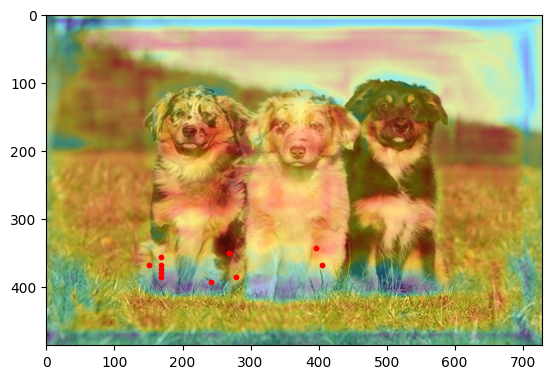

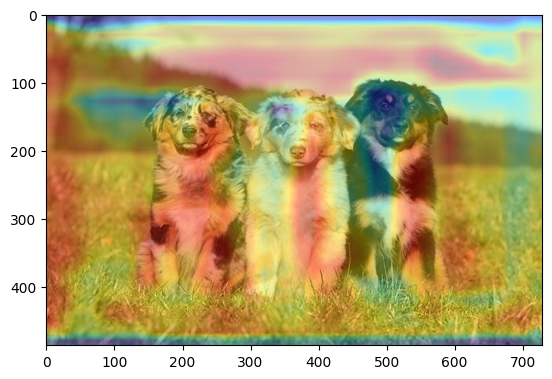

1.0


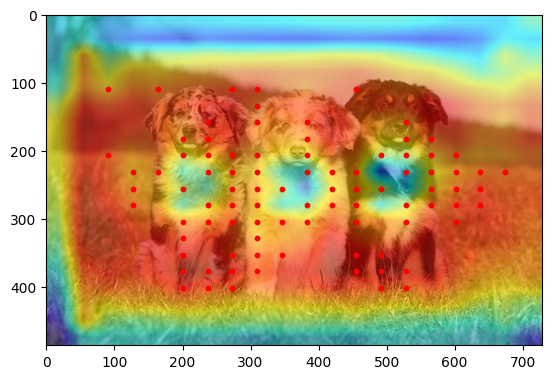

In [16]:
# 히트맵 생성
temp_feat_0 = sigmoid(encoder_feature[0].detach().cpu().numpy())
temp_feat_1 = sigmoid(encoder_feature[1].detach().cpu().numpy())
temp_feat_2 = sigmoid(encoder_feature[2].detach().cpu().numpy())


heatmap_0 = np.mean(temp_feat_0, axis=1).squeeze() # 채널 평균
heatmap_0 = cv2.resize(heatmap_0, (image.width, image.height)) # 이미지 크기로 조정
heatmap_0 = (heatmap_0 - np.min(heatmap_0)) / (np.max(heatmap_0) - np.min(heatmap_0))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_0), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[0]) / 640 * image.width
y = np.array(feats_idx_y[0]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()


heatmap_1 = np.mean(temp_feat_1, axis=1).squeeze() # 채널 평균
heatmap_1 = cv2.resize(heatmap_1, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_1 = heatmap_1 / np.max(heatmap_1)
heatmap_1 = (heatmap_1 - np.min(heatmap_1)) / (np.max(heatmap_1) - np.min(heatmap_1))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_1), cv2.COLORMAP_JET)
overlayed_image = heatmap * 0.5 + np.array(image)
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[1]) / 640 * image.width
y = np.array(feats_idx_y[1]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

heatmap_2 = np.mean(temp_feat_2, axis=1).squeeze() # 채널 평균
heatmap_2 = cv2.resize(heatmap_2, (image.width, image.height)) # 이미지 크기로 조정
heatmap_2 = (heatmap_2 - np.min(heatmap_2)) / (np.max(heatmap_2) - np.min(heatmap_2))
print(np.max(heatmap_2))
# 원본 이미지에 히트맵 겹치기
heatmap_2 = cv2.applyColorMap(np.uint8(255 * heatmap_2), cv2.COLORMAP_JET)
overlayed_image = heatmap_2 * 0.5 + np.array(image) * 0.5
overlayed_image = overlayed_image / np.max(overlayed_image)
x = np.array(feats_idx_x[2]) / 640 * image.width
y = np.array(feats_idx_y[2]) / 640 * image.height
plt.scatter(x, y, s=10, c='red', marker='o')
# 시각화
plt.imshow(overlayed_image)
plt.show()

In [17]:
# import requests
# import torchvision
# from PIL import Image
# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image = Image.open(requests.get(image_url, stream=True).raw)


# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((640,640)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# input_tensor = transform(image)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_tensor = input_tensor.to(device)
# # Add a batch dimension:
# input_tensor = input_tensor.unsqueeze(0)
# print(input_tensor.shape)

# # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# # model.eval().to(device)

# # Run the model and display the detections
# boxes, scores, labels = predict(input_tensor, model, device, 0.5)
# image = draw_boxes(boxes, image)
# image
